In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation

import numpy as np

import torch
import torch.nn

import torchsummary

from tqdm.notebook import tqdm

In [2]:
target = 0.9
def loss_function(x_all, mse=False, all_game_steps=False):
    if not all_game_steps:
        x_all = x_all[:, -1]
    x_dist = x_all - target
    if mse:
        loss = (x_dist**2).mean()        
    else:
        loss = -torch.exp(-x_dist**2).mean()
    
    return loss

def simulation(model_o, x_init, tp=False, clamp_val=(-1,1)):
    x_current = x_init
    x_all = [x_current]
    
    bs = x_init.shape[0]
    for i in range(100):
        tss = (i/(100-1)) * torch.ones(bs, 1)*0.0
        x_current = x_current.clone()
        x_move = model_o(x_current, tss)
        if tp:
            x_current = x_move
        else:
            x_current = (x_current + 0.02*x_move)
        
        if clamp_val is not None:
            x_current = x_current.clamp(*clamp_val)
        x_all.append(x_current)
    return torch.cat(x_all, dim=-1)

def plot_graph(x_all, ax=None, line_vals=[1., target], ylim=(-1.1, 1.1)):
    if ax is None:
        ax = plt.gca()
    ax.plot(np.arange(len(x_all[0])), x_all[0].detach().numpy())
    for line_val in line_vals:  
        ax.plot(np.arange(len(x_all[0])), np.ones(x_all[0].shape)*line_val)
    ax.set_ylim(*ylim)

In [3]:
def get_dense_layers(num_features):

    acts = [torch.nn.Tanh() for _ in num_features[1:-1]]
    acts.append(torch.nn.Identity())
    layers = []
    for num_in, num_out, act in zip(num_features, num_features[1:], acts):
        layers.extend((torch.nn.Linear(num_in, num_out), act))
    return torch.nn.Sequential(*layers)


class OffenseModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.main = get_dense_layers([2, 100, 100, 1])

    def forward(self, X, tss):
        X = X.view(-1, 1)
        X = torch.cat((X, tss), dim=-1)
        X = self.main(X)
        X = X.view(-1, 1)
        X = torch.tanh(X)
        return X
    
model_o = OffenseModel()
torchsummary.summary(model_o, [(1, ), (1, )])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             300
              Tanh-2                  [-1, 100]               0
            Linear-3                  [-1, 100]          10,100
              Tanh-4                  [-1, 100]               0
            Linear-5                    [-1, 1]             101
          Identity-6                    [-1, 1]               0
Total params: 10,501
Trainable params: 10,501
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


tp:False, mse:False, all:False, gf:randn
Before Loss:  -0.9749987721443176



After Loss:  -0.9998926520347595


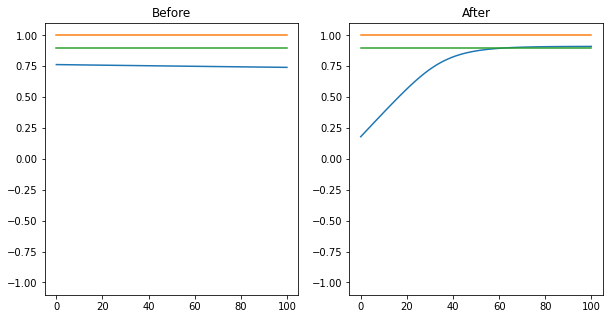

In [10]:
for tp in [False]:
    for mse in [False]:
        for all_game_steps in [False]:
            for generate_func in [torch.randn]:
                print(f'tp:{tp}, mse:{mse}, all:{all_game_steps}, gf:{generate_func.__name__}')
                
                model_o = OffenseModel()
                
                x_all = simulation(model_o, generate_func(1, 1), tp=tp)
                print('Before Loss: ', loss_function(x_all, mse=mse, all_game_steps=all_game_steps).item())
                fig, axs = plt.subplots(1, 2, figsize=(10,5))
                plot_graph(x_all, axs[0])
                axs[0].set_title('Before')
                

                opt = torch.optim.Adam(model_o.parameters())

                pbar = tqdm(range(200), desc='Optimization')
                for epoch in pbar:
                    x_all = simulation(model_o, generate_func(19, 1), tp=tp, clamp_val=None)

                    loss = loss_function(x_all, mse=mse, all_game_steps=all_game_steps)
                    opt.zero_grad()
                    loss.backward()
                    grad_max = 0.0
                    for params in model_o.parameters():
                        grad = params.grad.abs().max() 
                        if grad>grad_max:
                            grad_max = grad
                    opt.step()
                    pbar.set_postfix({'Loss ': loss.item(), 'Grad Max': grad_max})
                x_all = simulation(model_o, generate_func(1, 1), tp=tp)
                print('After Loss: ', loss_function(x_all, mse=mse, all_game_steps=all_game_steps).item())
                
#                 plt.subplot(1, 2, 2)
                plot_graph(x_all, axs[1])
                axs[1].set_title('After')
                plt.show()

things to mess around with:

- simulation by player steps vs player teleport
- loss function (guassian loss vs MSE loss)
- only last game_step vs all game_steps in loss function
- start from only zeros vs randn

---

- add timestamp to model input
- collision physics strict vs in loss function vs both


tp = True
mse = True
all_game_steps = True
generate_func = torch.zeros

converges to 0.9 in around 100 steps (not 50)

---

tp = True
mse = True
all_game_steps = True
generate_func = torch.randn

converges to 0.9 in around 100 steps (not 50) in all random starts

---

tp = True
mse = True
all_game_steps = False
generate_func = torch.zeros

converges to 0.9 in around 100 steps (not 50)

--- 

tp = True
mse = True
all_game_steps = False
generate_func = torch.randn

converges to 0.9 in around 100 steps (not 50) in all random starts

---

tp = True
mse = False
all_game_steps = True
generate_func = torch.zeros

converges to 0.9 in around 100 steps (not 50)

--- 

tp = True
mse = False
all_game_steps = True
generate_func = torch.randn

converges to 0.9 in around 100 steps (not 50) in all random starts

--- 
tp = True
mse = False
all_game_steps = False
generate_func = torch.zeros

converges to 0.9 in around 100 steps (not 50)

---

tp = True
mse = False
all_game_steps = False
generate_func = torch.randn

converges to 0.9 in around 100 steps (not 50) in all random starts


tp = False
mse = True
all_game_steps = True
generate_func = torch.zeros

NOPE, goes to 1 ASAP

---

tp = False
mse = True
all_game_steps = True
generate_func = torch.randn

NOPE, goes to 1 ASAP

---

tp = False
mse = True
all_game_steps = False
generate_func = torch.zeros

NOPE, goes to 1 ASAP

---

tp = False
mse = True
all_game_steps = False
generate_func = torch.randn

converges to 0.9 in around 150 steps (not 50) in all random starts

---

tp = False
mse = False
all_game_steps = True
generate_func = torch.zeros

NOPE, goes to 1 ASAP


---

tp = False
mse = False
all_game_steps = True
generate_func = torch.randn

NOPE, goes to 1 ASAP


---

tp = False
mse = False
all_game_steps = False
generate_func = torch.zeros

NOPE, goes to 1 ASAP

---

tp = False
mse = False
all_game_steps = False
generate_func = torch.randn

NOPE, goes to 1 ASAP
